In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torch.autograd import grad
import matplotlib.pyplot as plt
from IPython.display import clear_output
import matplotlib.animation as animation
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
def plot_loss(total, pde, boundary, initial):
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
    fig.tight_layout(pad=5.0)
    fig.suptitle('Training Losses')

    metrics = [total,pde,initial,boundary]
    labels = ['Total Loss','PDE Loss','Initial Loss','Boundary Loss']
    for i in range(2): # Overall and Recent 
        for j in range(4): # Four Metrics
            ax[j,i].plot(metrics[j] if i == 0 else metrics[j][:-1000])
            ax[j,i].set_title(labels[j] if i == 0 else "Last 1000 " + labels[j])
            ax[j,i].set_xlabel('Epoch')
            ax[j,i].set_ylabel('Loss')
    plt.show()

In [15]:
class HeatData(Dataset):
    def __init__(self, csv):
        self.data = pd.read_csv(csv)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        features = self.data.iloc[index, :-1].values.astype(float)
        labels = self.data.iloc[index, -1]
        return features, labels
    
InitialDataset = HeatData('Datasets/HeatDataInitial.csv')
BoundaryDataset = HeatData('Datasets/HeatDataBoundary.csv')
CollocDataset = HeatData('Datasets/HeatDataColloc.csv')

InitialDataLoader = DataLoader(InitialDataset,batch_size=1000,shuffle=True)
BoundaryDataLoader = DataLoader(BoundaryDataset,batch_size=1000,shuffle=True)
CollocDataLoader = DataLoader(CollocDataset,batch_size=1000,shuffle=True)

In [17]:
class HeatPINN(nn.Module):
    def __init__(self):
        super(HeatPINN, self).__init__()

        self.inpLayer = nn.Linear(3,50)
        self.fcLayer = nn.Linear(50,50)
        self.outLayer = nn.Linear(50,1)
        self.activationFunc = nn.SiLU()

    def forward(self, x):
        
        x = self.inpLayer(x)
        x = self.activationFunc(x)

        for _ in range(8):
            x = self.fcLayer(x)
            x = self.activationFunc(x)

        x = self.outLayer(x)

        return x
    
PINN = HeatPINN().to(device)

In [19]:
def pde_residual_loss(x, alpha=1):
    x.requires_grad = True
    u = PINN(x)
    u = u.reshape(-1, 1)
    grad_u = torch.autograd.grad(outputs=u, inputs=x,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph=True, retain_graph=True)[0]
    
    u_x = grad_u[:, 0].unsqueeze(1)
    u_y = grad_u[:, 1].unsqueeze(1)
    u_t = grad_u[:, 2].unsqueeze(1)
    
    u_xx = torch.autograd.grad(outputs=u_x, inputs=x,
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0][:, 0].unsqueeze(1)
    u_yy = torch.autograd.grad(outputs=u_y, inputs=x,
                               grad_outputs=torch.ones_like(u_y),
                               create_graph=True)[0][:, 1].unsqueeze(1)

    residual = u_t - alpha * (u_xx + u_yy)
    loss = torch.mean(residual**2)
    return loss

def boundary_loss(x):
    u_boundary = PINN(x)
    u_boundary = u_boundary.reshape(-1, 1)
    loss = torch.mean(u_boundary**2)
    return loss

# Define the loss function for initial conditions
def initial_loss(x, sigma=0.2, x_center=0.5, y_center=0.5):
    u_initial = PINN(x)
    u_initial = u_initial.reshape(-1, 1)
    gaussian = torch.exp(-((x[:, 0] - x_center)**2 + (x[:, 1] - y_center)**2) / (2 * sigma**2)).unsqueeze(1)
    loss = torch.mean((u_initial - gaussian)**2)
    return loss

In [21]:
optimizer = torch.optim.Adam(PINN.parameters(),lr=1e-4)

num_epochs = 5000

loss_weights = {'collocation': 2, 'boundary': 1, 'initial': 1}

train_metrics = {'total_loss': [],'pde_loss': [],'boundary_loss': [], 'initial_loss': []}

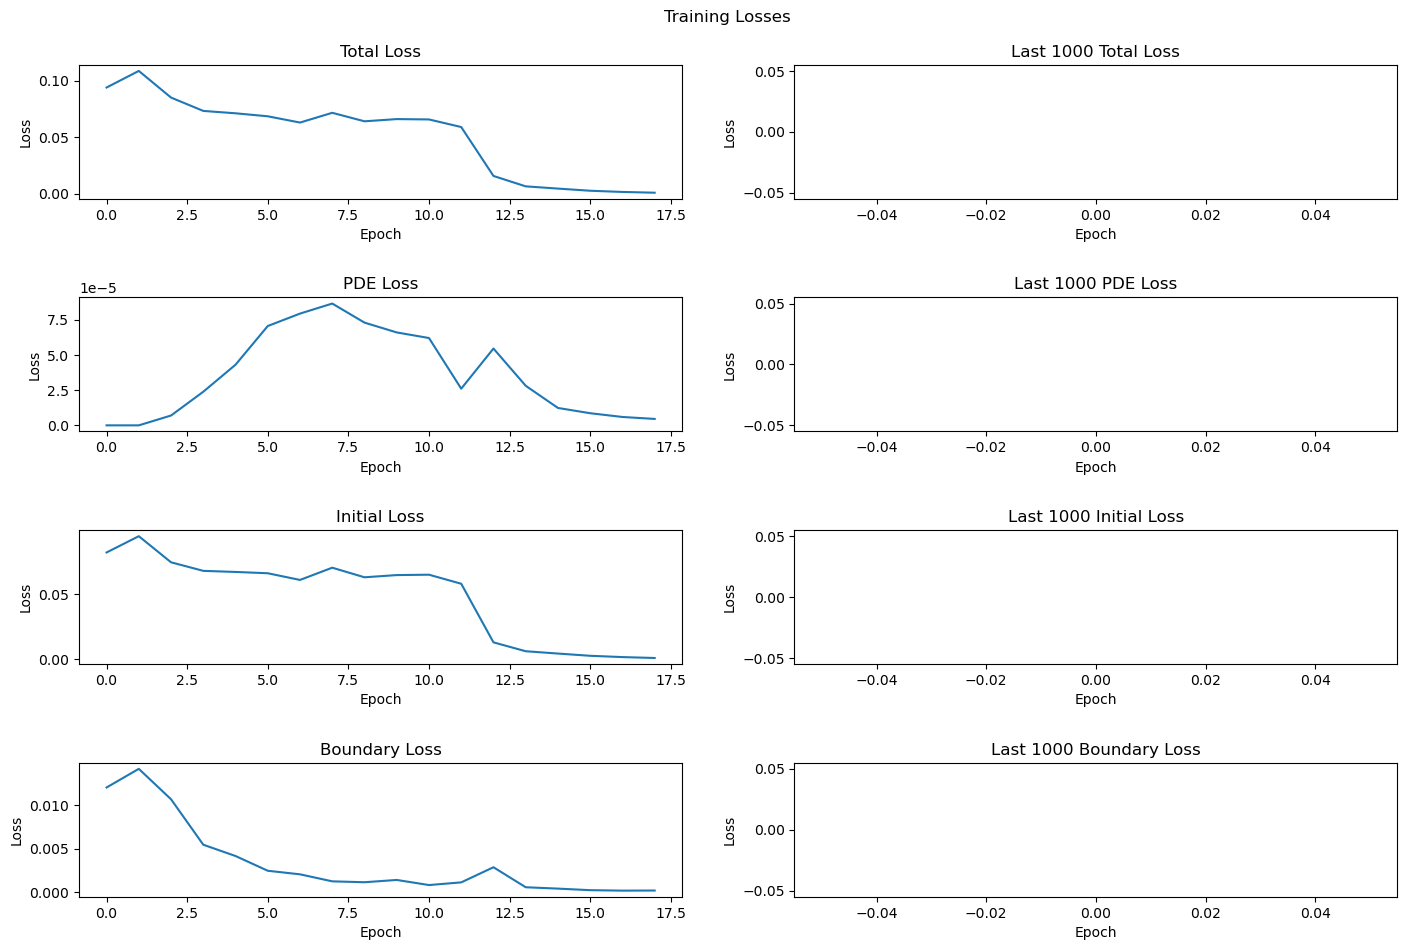

Epoch: 160, Loss: 0.001022228505462408, PDE: 4.563999482343206e-06, BND: 0.00017848442075774074, INIT: 0.0008346161339432001


KeyboardInterrupt: 

In [25]:
for epoch in range(num_epochs):
    for collocation_batch, boundary_batch, initial_batch in zip(CollocDataLoader, BoundaryDataLoader, InitialDataLoader):
        # Zero the gradients
        optimizer.zero_grad()

        # Compute the PDE residual loss
        collocation_input = collocation_batch[0]
        collocation_input = collocation_input.to(torch.float32).to(device)

        pde_loss = pde_residual_loss(collocation_input)

        # Compute the boundary loss
        boundary_input = boundary_batch[0]
        boundary_input = boundary_input.to(torch.float32).to(device)
        
        bnd_loss = boundary_loss(boundary_input)

        # Compute the initial loss
        initial_input = initial_batch[0]
        initial_input = initial_input.to(torch.float32).to(device)
        
        init_loss = initial_loss(initial_input)

        # Combine the losses
        total_loss = (loss_weights['collocation'] * pde_loss +
                      loss_weights['boundary'] * bnd_loss +
                      loss_weights['initial'] * init_loss)

        # Compute the gradients and update the weights
        total_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            
            total_loss = total_loss.item()
            pde_loss = pde_loss.item()
            bnd_loss = bnd_loss.item()
            init_loss = init_loss.item()

            train_metrics['total_loss'].append(total_loss)
            train_metrics['pde_loss'].append(pde_loss)
            train_metrics['boundary_loss'].append(bnd_loss)
            train_metrics['initial_loss'].append(init_loss)
            
        clear_output(wait=True)
        plot_loss(train_metrics['total_loss'],train_metrics['pde_loss'],train_metrics['boundary_loss'],train_metrics['initial_loss'])
        print(f"Epoch: {epoch}, Loss: {total_loss}, PDE: {pde_loss}, BND: {bnd_loss}, INIT: {init_loss}")

In [8]:
torch.save(PINN.state_dict(), '.pth')

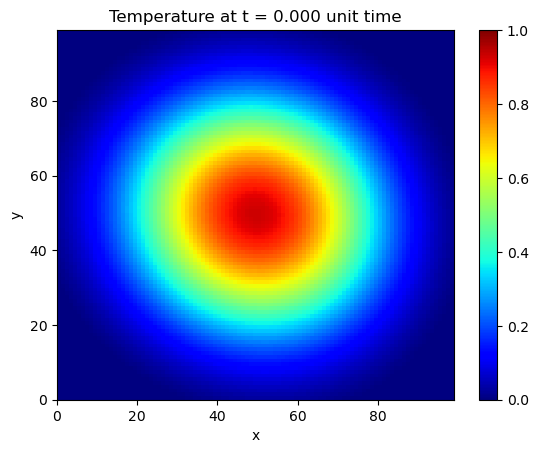

In [31]:
x = torch.linspace(0, 1, 99)
y = torch.linspace(0, 1, 99)
t = torch.linspace(0, 1, 99)
xx, yy, tt = torch.meshgrid(x, y, t)


coords = torch.stack((xx.flatten(), yy.flatten(), tt.flatten()), dim=1).to(device)

out = PINN(coords)
out = out.reshape(99, 99, 99).permute(2, 0, 1).to('cpu').detach().numpy()

def plotheatmap(u_k, k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Temperature at t = {k*(1/8):.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=1)
    plt.colorbar()

    return plt

def animate(k):
    plotheatmap(out[k], k)

from IPython.display import HTML
anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=99, repeat=False)
HTML(anim.to_jshtml())